# Algoritmo de red convolucional para la clasificación detección temprana de supernovas

In [59]:
import numpy as np
import pickle as pkl
import os
import sys
import time
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report

## Red convolucional

### Se abre la data pre-procesada

In [45]:
# Función para cargar el contenido del archivo .pkl
def load_pickle_data(filename):
    with open(filename, 'rb') as f:
        data = pkl.load(f)
    return data

# Cargar el archivo
filename = 'processed_data.pkl' 
data_procesada = load_pickle_data(filename)

# Visualizar el contenido
print('keys de pkl', data_procesada.keys())
print('keys de Test',data_procesada['Validation'].keys())
data_procesada['Validation']['labels']

keys de pkl dict_keys(['Train', 'Validation', 'Test'])
keys de Test dict_keys(['images', 'labels', 'features'])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [46]:
def preparar_imagenes_para_modelo(data_dict, key_principal='Train', key_imagenes='images'):
    # Extraer imágenes del diccionario
    imagenes = data_dict[key_principal][key_imagenes]
    
    # Cambiar el orden de las dimensiones a [canales, altura, ancho]
    imagenes = np.transpose(imagenes, (0, 3, 1, 2))
    
    # Convertir a tensor de PyTorch
    imagenes_tensor = torch.tensor(imagenes, dtype=torch.float32)

    
    return imagenes_tensor

# Preparar las imágenes para el modelo
Train = preparar_imagenes_para_modelo(data_procesada)
Val = preparar_imagenes_para_modelo(data_procesada, key_principal='Validation')
Test = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')

print('tipo de dato de Train:', Train.type)
print('forma de Train:', Train.shape)
print('forma de Validation:', Val.shape)
print('forma de Test:', Test.shape)



tipo de dato de Train: <built-in method type of Tensor object at 0x0000011F9ABC6160>
forma de Train: torch.Size([72710, 3, 21, 21])
forma de Validation: torch.Size([500, 3, 21, 21])
forma de Test: torch.Size([500, 3, 21, 21])


In [47]:
def extraer_etiquetas(data_dict, key_principal='Train', key_etiquetas='labels'):
    # Extraer etiquetas del diccionario
    etiquetas = data_dict[key_principal][key_etiquetas]
    # Convertir a tensor de PyTorch
    etiquetas_tensor = torch.tensor(etiquetas, dtype=torch.long)  # Usamos dtype long porque son índices de clase
    return etiquetas_tensor


### Extracción de metadata:

In [48]:
def extraer_metadata(data_dict, key_principal='Train', key_metadata='features'):
    # Extraer características de metadatos del diccionario
    metadata = data_dict[key_principal][key_metadata]
    
    # Convertir explícitamente a float32
    metadata = metadata.astype(np.float32)
    
    # Convertir a tensor de PyTorch
    metadata_tensor = torch.tensor(metadata, dtype=torch.float32)
    
    return metadata_tensor


# Extraer características de metadatos para los conjuntos de datos
metadata_train = extraer_metadata(data_procesada)
metadata_val = extraer_metadata(data_procesada, key_principal='Validation')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

print('forma de metadata_train:', metadata_train.shape)
print('forma de metadata_val:', metadata_val.shape)
print('forma de metadata_test:', metadata_test.shape)

metadata_val[0]


forma de metadata_train: torch.Size([72710, 26])
forma de metadata_val: torch.Size([500, 26])
forma de metadata_test: torch.Size([500, 26])


tensor([ 0.7788, -0.6295,  0.0887,  0.4651,  1.1523,  0.0935,  2.1225, -0.8817,
         1.1350,  1.1945,  0.2198,  0.3951,  1.1309,  0.9652, -0.6643, -0.0798,
        -2.0312, -0.2051, -0.1635,  0.5879,  0.2048,  1.6357, -0.8917, -0.1424,
        -0.2300, -0.1352])

## Modelo convolucional, incorporando invariancia rotacional

In [49]:
class CNNModel(nn.Module):
    def __init__(self, dropout_p, num_classes=5):
        super().__init__()
        # Zero padding para evitar perder datos de las imágenes después de las convoluciones
        self.padding = nn.ZeroPad2d(3)

        # Bloques de convolución
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # MLP
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def rotate_input(self, x):
        # Rotaciones para la invariancia 
        x_90 = torch.rot90(x, 1, [2, 3])
        x_180 = torch.rot90(x, 2, [2, 3])
        x_270 = torch.rot90(x, 3, [2, 3])
        return torch.cat([x, x_90, x_180, x_270], dim=0)

    def cyclic_pooling(self, x):
        B = x.size(0) // 4
        return (x[:B] + x[B:2*B] + x[2*B:3*B] + x[3*B:]) / 4.0

    def forward(self, x):
        # Zero padding
        x = self.padding(x)
        
        # Rotación de la entrada
        x_rotated = self.rotate_input(x)
        
        # Pasar por bloques convolucionales
        x_rotated = self.conv_blocks(x_rotated)
        
        # Pooling Cíclico
        x_pooled = self.cyclic_pooling(x_rotated)
        
        # Pasar por MLP
        out = self.mlp(x_pooled)
        
        return out


## Función de entrenamiento y visualización

In [50]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [51]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss



def train_model(
    model,
    train_data_images,
    train_data_labels,
    val_data_images,
    val_data_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu,
    patience=5
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_dataset = torch.utils.data.TensorDataset(train_data_images, train_data_labels)
    val_dataset = torch.utils.data.TensorDataset(val_data_images, val_data_labels)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_data_images), shuffle=False, pin_memory=use_gpu)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()

        for i, data in enumerate(train_loader):
            (x_batch, y_batch) = data  
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i + 1) % 117 == 0:
                print(f"Iteration {i + 1} - Batch {i + 1}/{len(train_loader)} - Train loss: {cumulative_train_loss / train_loss_count}, Train acc: {cumulative_train_corrects / train_acc_count}")

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # Lógica de early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement after {patience} epochs.")
            break

    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")
    model.cpu()

    return curves


### Búsqueda de hiperparámetros con funciones de sklearn

In [52]:
# Dividir las imágenes y metadatos en conjuntos de entrenamiento y validación
Train_images = preparar_imagenes_para_modelo(data_procesada)
Val_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Validation')
Train_labels = extraer_etiquetas(data_procesada)
Val_labels = extraer_etiquetas(data_procesada, key_principal='Validation')


In [55]:
# Wrapper del modelo para Scikit-learn
class TorchModelWrapper(object):
    def __init__(self, dropout_p=0.5, batch_size=64, lr=0.001, epochs=30, use_gpu=True):
        self.dropout_p = dropout_p
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.use_gpu = use_gpu
        self._model = None

    def get_params(self, deep=True):
        return {
            "dropout_p": self.dropout_p,
            "batch_size": self.batch_size,
            "lr": self.lr,
            "epochs": self.epochs,
            "use_gpu": self.use_gpu
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def fit(self, X, y):
        model = CNNModel(dropout_p=self.dropout_p)
        criterion = nn.CrossEntropyLoss()
        
        self._model = train_model(model, X, y, Val_images, Val_labels, self.epochs, criterion, self.batch_size, self.lr, self.use_gpu)

    def predict(self, X):
        dataset = torch.utils.data.TensorDataset(X)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(X), shuffle=False)
        
        self._model.eval()
        with torch.no_grad():
            for inputs in data_loader:
                if self.use_gpu:
                    inputs = inputs.cuda()
                outputs = self._model(inputs)
                _, preds = torch.max(outputs, 1)
        return preds.cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


# Parámetros a considerar en la búsqueda
param_dist = {
    'dropout_p': [0.5, 0.6, 0.8],
    'batch_size': [16, 32, 62],
    'lr': [5e-3, 1e-3, 5e-4, 1e-4, 5e-5],
    'epochs': [10, 20, 30, 40, 50]
}

# Crear el modelo de búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=TorchModelWrapper(),
    param_distributions=param_dist,
    n_iter=10,
    scoring=make_scorer(accuracy_score),
    verbose=1,
    cv=3,
    n_jobs=1
)

# Lanzar la búsqueda
random_search.fit(Train_images, Train_labels)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados: ", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/50
Iteration 117 - Batch 117/3030 - Train loss: 1.6098175374870627, Train acc: 0.202991452991453
Iteration 234 - Batch 234/3030 - Train loss: 1.60683015269092, Train acc: 0.21955128205128205
Iteration 351 - Batch 351/3030 - Train loss: 1.592263707747826, Train acc: 0.24465811965811965
Iteration 468 - Batch 468/3030 - Train loss: 1.5663935323046823, Train acc: 0.2765758547008547
Iteration 585 - Batch 585/3030 - Train loss: 1.532999097587716, Train acc: 0.30833333333333335
Iteration 702 - Batch 702/3030 - Train loss: 1.5004800415446615, Train acc: 0.333244301994302
Iteration 819 - Batch 819/3030 - Train loss: 1.4662965285035716, Train acc: 0.35752442002442003
Iteration 936 - Batch 936/3030 - Train loss: 1.4375426694113984, Train acc: 0.37580128205128205
Iteration 1053 - Batch 1053/3030 - Train loss: 1.4110672029561353, Train acc: 0.3922127255460589
Iteration 1170 - Batch 1170/3030 - Train loss: 1.3863321759252467, Train

c:\Users\milan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\milan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    result_msg += f"test={test_scores[scorer_name]:.3f})"
  File "c:\Users\milan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    Test data that will be fed to estimator.predict.
  File "c:\Users\milan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    ``self._kwargs`` and ``kwargs`` passed as metadata.
  File "c:\Users\milan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    homogeneity_score,


Iteration 117 - Batch 117/3030 - Train loss: 1.6098300147260356, Train acc: 0.2094017094017094
Iteration 234 - Batch 234/3030 - Train loss: 1.6053762272891836, Train acc: 0.22115384615384615
Iteration 351 - Batch 351/3030 - Train loss: 1.5905217567400376, Train acc: 0.25
Iteration 468 - Batch 468/3030 - Train loss: 1.5637160799442194, Train acc: 0.27737713675213677
Iteration 585 - Batch 585/3030 - Train loss: 1.540253694037087, Train acc: 0.2986111111111111
Iteration 702 - Batch 702/3030 - Train loss: 1.5165706254817821, Train acc: 0.317485754985755
Iteration 819 - Batch 819/3030 - Train loss: 1.4901832426569546, Train acc: 0.33814102564102566
Iteration 936 - Batch 936/3030 - Train loss: 1.465917016260135, Train acc: 0.3550347222222222
Iteration 1053 - Batch 1053/3030 - Train loss: 1.4449394119431151, Train acc: 0.3691832858499525
Iteration 1170 - Batch 1170/3030 - Train loss: 1.4216750134260228, Train acc: 0.38344017094017097
Iteration 1287 - Batch 1287/3030 - Train loss: 1.4022495889

c:\Users\milan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Iteration 117 - Batch 117/4545 - Train loss: 1.612349682384067, Train acc: 0.2013888888888889
Iteration 234 - Batch 234/4545 - Train loss: 1.6105858861890614, Train acc: 0.19951923076923078
Iteration 351 - Batch 351/4545 - Train loss: 1.587591045942062, Train acc: 0.23326210826210828
Iteration 468 - Batch 468/4545 - Train loss: 1.5582270214700291, Train acc: 0.2609508547008547
Iteration 585 - Batch 585/4545 - Train loss: 1.531363909264915, Train acc: 0.28920940170940174
Iteration 702 - Batch 702/4545 - Train loss: 1.507793965332868, Train acc: 0.31285612535612534
Iteration 819 - Batch 819/4545 - Train loss: 1.4871652124128936, Train acc: 0.3340201465201465
Iteration 936 - Batch 936/4545 - Train loss: 1.4656940349656293, Train acc: 0.3504273504273504
Iteration 1053 - Batch 1053/4545 - Train loss: 1.4470795101476417, Train acc: 0.36651234567901236
Iteration 1170 - Batch 1170/4545 - Train loss: 1.4251125060594998, Train acc: 0.38087606837606836
Iteration 1287 - Batch 1287/4545 - Train los

#### Mejores parámetros encontrados:  {'lr': 5e-05, 'epochs': 50, 'dropout_p': 0.6, 'batch_size': 16}

## Instanciamos el modelo

Epoch 1/50
Iteration 117 - Batch 117/4545 - Train loss: 1.6074765981772008, Train acc: 0.23397435897435898
Iteration 234 - Batch 234/4545 - Train loss: 1.6077633031413086, Train acc: 0.21875
Iteration 351 - Batch 351/4545 - Train loss: 1.5928913123926884, Train acc: 0.24697293447293447
Iteration 468 - Batch 468/4545 - Train loss: 1.554276876215242, Train acc: 0.28378739316239315
Iteration 585 - Batch 585/4545 - Train loss: 1.519529754280025, Train acc: 0.3141025641025641
Iteration 702 - Batch 702/4545 - Train loss: 1.4883436166662776, Train acc: 0.33582621082621084
Iteration 819 - Batch 819/4545 - Train loss: 1.464015001124078, Train acc: 0.3570665445665446
Iteration 936 - Batch 936/4545 - Train loss: 1.4416002417222047, Train acc: 0.37246260683760685
Iteration 1053 - Batch 1053/4545 - Train loss: 1.4217236058438039, Train acc: 0.38829534662868
Iteration 1170 - Batch 1170/4545 - Train loss: 1.4010073415744, Train acc: 0.4014957264957265
Iteration 1287 - Batch 1287/4545 - Train loss: 1.

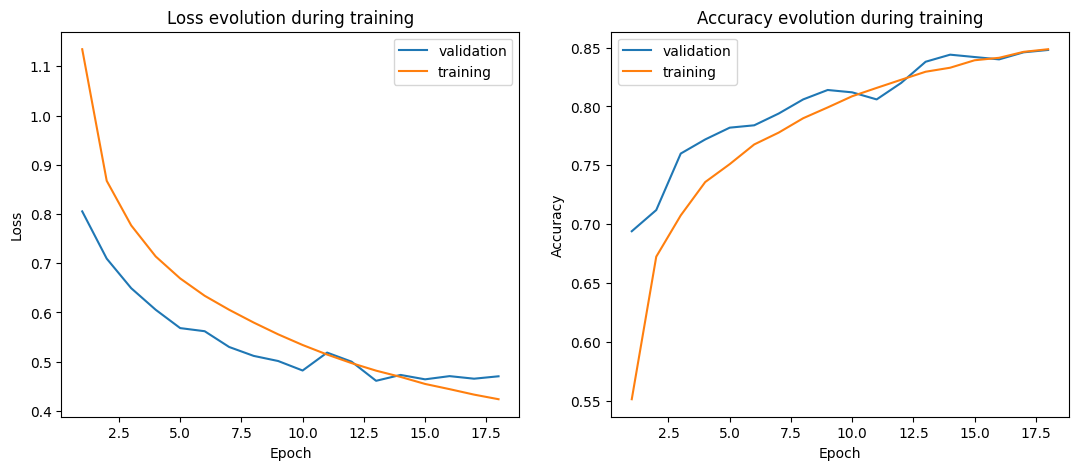

In [58]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.6
batch_size = 16
criterion = nn.CrossEntropyLoss()
epochs = 50
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    Val_images,    
    Val_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
)

# Mostrar las curvas de entrenamiento
show_curves(curves)



              precision    recall  f1-score   support

         AGN       0.88      0.79      0.83       100
          SN       0.84      0.78      0.81       100
          VS       0.82      0.89      0.86       100
    asteroid       0.81      0.94      0.87       100
       bogus       0.92      0.86      0.89       100

    accuracy                           0.85       500
   macro avg       0.86      0.85      0.85       500
weighted avg       0.86      0.85      0.85       500



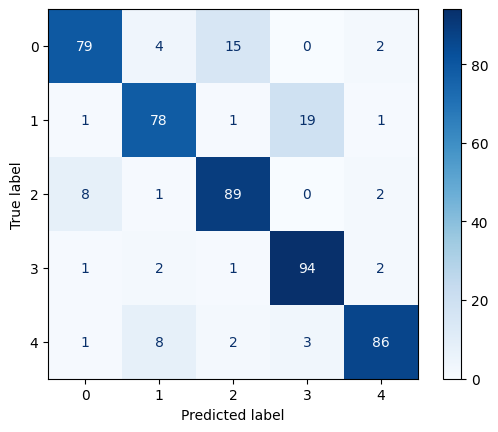

In [61]:
def predict(model, data_loader, use_gpu):
    all_preds = []
    all_true = []
    
    if use_gpu:
        model = model.cuda()  # Transfiere el modelo a la GPU
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            if use_gpu:
                inputs = inputs.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.numpy())

    return all_true, all_preds

Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

# Asume que ya has obtenido true_labels y predicted_labels, como en el código anterior
report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)


Epoch 1/50
Iteration 117 - Batch 117/2273 - Train loss: 1.611445421846504, Train acc: 0.19417735042735043
Iteration 234 - Batch 234/2273 - Train loss: 1.6037703344964573, Train acc: 0.21674679487179488
Iteration 351 - Batch 351/2273 - Train loss: 1.5815222745607382, Train acc: 0.25258190883190884
Iteration 468 - Batch 468/2273 - Train loss: 1.5540312161812415, Train acc: 0.28552350427350426
Iteration 585 - Batch 585/2273 - Train loss: 1.527955819806482, Train acc: 0.3138888888888889
Iteration 702 - Batch 702/2273 - Train loss: 1.5004308138817464, Train acc: 0.33738425925925924
Iteration 819 - Batch 819/2273 - Train loss: 1.472836331642882, Train acc: 0.3582493894993895
Iteration 936 - Batch 936/2273 - Train loss: 1.4474922081089427, Train acc: 0.3764356303418803
Iteration 1053 - Batch 1053/2273 - Train loss: 1.4224743537979814, Train acc: 0.392687559354226
Iteration 1170 - Batch 1170/2273 - Train loss: 1.4007956092174236, Train acc: 0.4067040598290598
Iteration 1287 - Batch 1287/2273 -

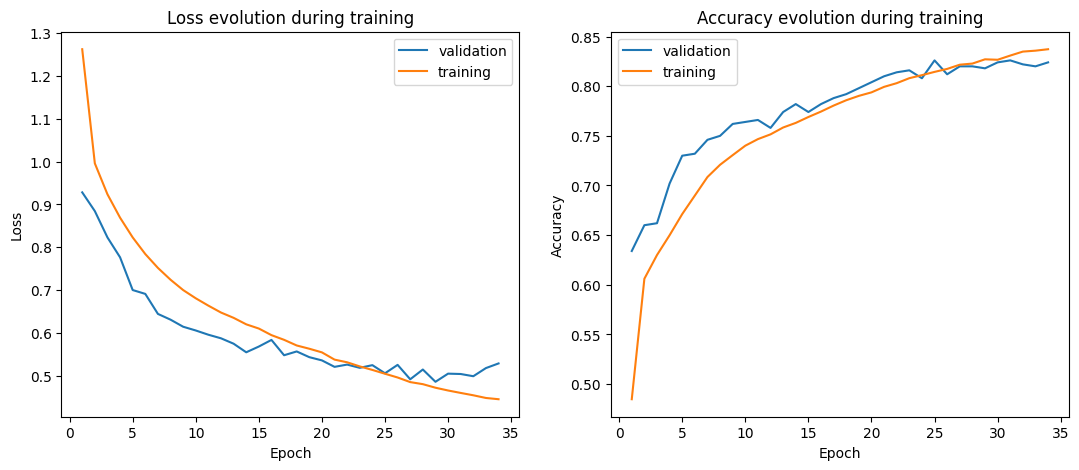

In [62]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.6
batch_size = 32
criterion = nn.CrossEntropyLoss()
epochs = 50
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    Val_images,    
    Val_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
)

# Mostrar las curvas de entrenamiento
show_curves(curves)


              precision    recall  f1-score   support

         AGN       0.82      0.82      0.82       100
          SN       0.81      0.68      0.74       100
          VS       0.85      0.85      0.85       100
    asteroid       0.87      0.87      0.87       100
       bogus       0.79      0.92      0.85       100

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



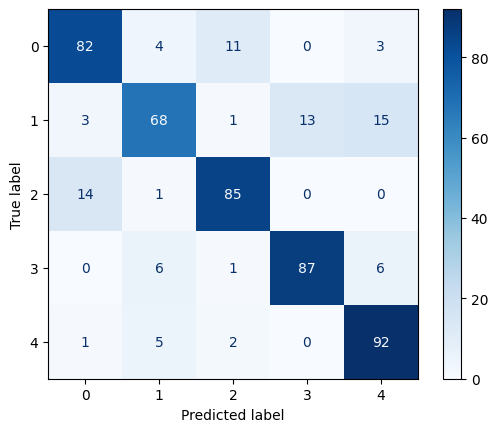

In [63]:
def predict(model, data_loader, use_gpu):
    all_preds = []
    all_true = []
    
    if use_gpu:
        model = model.cuda()  # Transfiere el modelo a la GPU
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            if use_gpu:
                inputs = inputs.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.numpy())

    return all_true, all_preds

Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

# Asume que ya has obtenido true_labels y predicted_labels, como en el código anterior
report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)
